# 1. Preprocessing

The "surpirse" package needs a specific layout of the datafile. We are using "pandas" to shape our original dataset into the form we need.

user ; item ; rating ; [timestamp]

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("train.csv")
data.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


In [3]:
df = data.copy()

# create a mapping for media ids
unique_media_ids = set(df["media_id"].values)
media2idx = {}
count = 0
for media_id in unique_media_ids:
    media2idx[media_id] = count
    count += 1

# add them to the data frame
df["media_idx"] = df.apply(lambda row: media2idx[row["media_id"]], axis=1)

In [4]:
df = df[["user_id","media_idx","is_listened"]]
df

,user_id,media_idx,is_listened
0,9241,100003,0
1,16547,111381,1
2,7665,132806,1
3,1580,384690,0
4,1812,232521,1
...,...,...,...
7558829,2592,9859,0
7558830,9028,121136,0
7558831,393,143462,0
7558832,4507,143463,1


## 1.1 Creating smaller DataFrame for modeling

In [5]:
from collections import Counter

In [6]:
print("original dataframe size:", len(df))

original dataframe size: 7558834


In [7]:
N = len(df["user_id"].unique()) # Number of users
M = len(df["media_idx"].unique()) # Number of medias

# counts the number of appearances and returns a dictionary
user_ids_count = Counter(df["user_id"])
media_ids_count = Counter(df["media_idx"])

# number of users and media we would like to keep
n = 1000
m = 200

user_ids = [u for u, c in user_ids_count.most_common(n)]
media_ids = [m for m, c in media_ids_count.most_common(m)]

# make a copy, otherwise ids won't be overwritten
df_small = df[df["user_id"].isin(user_ids) & df["media_idx"].isin(media_ids)].copy()
df_small

,user_id,media_idx,is_listened
31026,815,283668,1
31027,815,283668,1
31028,815,283668,1
31029,145,283668,0
31030,145,283668,0
...,...,...,...
7472796,117,337938,0
7472797,117,337938,0
7472800,719,337938,1
7472802,210,337938,0


In [8]:
# need to remake user ids and media ids since they are no longer sequential
new_user_id_map = {}
i = 0
for old in user_ids:
    new_user_id_map[old] = i
    i += 1
print("i:", i)

new_media_id_map = {}
j = 0
for old in media_ids:
    new_media_id_map[old] = j
    j += 1
print("j:", j)

print("Setting new ids")
df_small.loc[:, "user_id"] = df_small.apply(lambda row: new_user_id_map[row["user_id"]], axis=1)
df_small.loc[:, "media_idx"] = df_small.apply(lambda row: new_media_id_map[row["media_idx"]], axis=1)

print("max user id:", df_small["user_id"].max())
print("max movie id:", df_small["media_idx"].max())

print("small dataframe size:", len(df_small))

i: 1000
j: 200
Setting new ids
max user id: 999
max movie id: 199
small dataframe size: 237012


In [9]:
df_small.to_csv("./train_small.csv",sep = ";", index = False)

# 2. Surprise - Building a Recommender system

In [10]:
import pandas as pd

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

In [11]:
# Using df_small for testing/modeling
df = df_small.copy() # deleting this when using the whole dataset

reader = Reader(line_format = "user item rating", rating_scale=(0, 1))
rec_data = Dataset.load_from_df(df, reader)

## 2.1 User-based collaborative filtering

In [12]:
from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter

testSubject = 25 # User example
k = 30

trainSet = rec_data.build_full_trainset()

sim_options_user = {"name": "cosine",
                    "user_based": True}

model = KNNBasic(sim_options=sim_options_user, verbose=False)
model.fit(trainSet)
simsMatrix = model.compute_similarities()

# Get top N similar users to our test subject
# (Alternate approach would be to select users up to some similarity threshold - try it!)
testUserInnerID = trainSet.to_inner_uid(testSubject)
similarityRow = simsMatrix[testUserInnerID]

similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        similarUsers.append((innerID, score))
        
# drop similarity scores corresponsing to np.nan
similarUsers_new = []
for i in similarUsers:
    if np.isnan(i[1]):
        continue
    else:
        similarUsers_new.append(i)
        
kNeighbors = heapq.nlargest(k, similarUsers_new, key=lambda t: t[1])

# Get the stuff they rated, and add up ratings for each item, weighted by user similarity
candidates = defaultdict(float)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainSet.ur[innerID]
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore

# Build a dictionary of stuff the user has already listened to
listened = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    listened[itemID] = 1
    
# Get top-rated items from similar users:
print(f"For user {testSubject} the top 10 recommended music tracks are:")
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not itemID in listened:
        mediaID = trainSet.to_raw_iid(itemID)
        #print(ml.getMovieName(int(movieID)), ratingSum)
        print(f"MediaID {mediaID}: {ratingSum}")
        pos += 1
        if (pos > 10):
            break

/Users/Tom/opt/anaconda3/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


For user 25 the top 10 recommended music tracks are:
MediaID 105: 19.3313340510547
MediaID 54: 15.827550460527974
MediaID 31: 15.802519921709063
MediaID 1: 13.290290263366419
MediaID 66: 12.871191481047703
MediaID 35: 12.836715663642268
MediaID 177: 12.709357057813037
MediaID 186: 11.935755957818323
MediaID 8: 11.28119457617207
MediaID 182: 11.011691714690691
MediaID 21: 10.851500857824442


In [13]:
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import KFold

# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = KNNBasic(sim_options=sim_options_user, verbose=False)

for trainset, testset in kf.split(rec_data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.4606
RMSE: 0.4592
RMSE: 0.4587


## 2.2 Item-based collaborative filtering

In [14]:
from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter

testSubject = 85 
k = 10

trainSet = rec_data.build_full_trainset()

sim_options_item = {"name": "cosine",
                    "user_based": False}

model = KNNBasic(sim_options=sim_options_item, verbose=False)
model.fit(trainSet)
simsMatrix = model.compute_similarities()

testUserInnerID = trainSet.to_inner_uid(testSubject)

# Get the top K items we rated
testUserRatings = trainSet.ur[testUserInnerID]
kNeighbors = heapq.nlargest(k, testUserRatings, key=lambda t: t[1])

# Get the stuff they rated, and add up ratings for each item, weighted by user similarity
candidates = defaultdict(float)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainSet.ur[innerID]
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1] / 5.0)

# Build a dictionary of stuff the user has already listened to
listened = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    listened[itemID] = 1
    
# Get top-rated items from similar users:
print(f"For user {testSubject} the top 10 recommended music tracks are:")
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not itemID in listened:
        mediaID = trainSet.to_raw_iid(itemID)
        #print(ml.getMovieName(int(movieID)), ratingSum)
        print(f"MediaID {mediaID}: {ratingSum}")
        pos += 1
        if (pos > 10):
            break

For user 85 the top 10 recommended music tracks are:
MediaID 2: 129.00000000000122
MediaID 37: 121.80000000000119
MediaID 22: 117.80000000000113
MediaID 16: 113.40000000000107
MediaID 60: 95.20000000000081
MediaID 38: 93.8000000000008
MediaID 50: 79.8000000000006
MediaID 123: 72.8000000000005
MediaID 93: 54.600000000000236
MediaID 3: 51.40000000000019
MediaID 57: 36.39999999999998


In [15]:
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import KFold

# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = KNNBasic(sim_options=sim_options_item, verbose=False)

for trainset, testset in kf.split(rec_data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.3953
RMSE: 0.3959
RMSE: 0.3959


## 2.3 Matrix Factorization

In [16]:
from surprise import SVD
import heapq
from collections import defaultdict
from operator import itemgetter

testSubject = 85 
k = 10

trainSet = rec_data.build_full_trainset()

model = SVD()
model.fit(trainSet)
simsMatrix = model.compute_similarities()

testUserInnerID = trainSet.to_inner_uid(testSubject)

# Get the top K items we rated
testUserRatings = trainSet.ur[testUserInnerID]
kNeighbors = heapq.nlargest(k, testUserRatings, key=lambda t: t[1])

# Get the stuff they rated, and add up ratings for each item, weighted by user similarity
candidates = defaultdict(float)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainSet.ur[innerID]
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1] / 5.0)

# Build a dictionary of stuff the user has already listened to
listened = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    listened[itemID] = 1
    
# Get top-rated items from similar users:
print(f"For user {testSubject} the top 10 recommended music tracks are:")
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not itemID in listened:
        mediaID = trainSet.to_raw_iid(itemID)
        #print(ml.getMovieName(int(movieID)), ratingSum)
        print(f"MediaID {mediaID}: {ratingSum}")
        pos += 1
        if (pos > 10):
            break

For user 85 the top 10 recommended music tracks are:
MediaID 2: 129.00000000000122
MediaID 37: 121.80000000000119
MediaID 22: 117.80000000000113
MediaID 16: 113.40000000000107
MediaID 60: 95.20000000000081
MediaID 38: 93.8000000000008
MediaID 50: 79.8000000000006
MediaID 123: 72.8000000000005
MediaID 93: 54.600000000000236
MediaID 3: 51.40000000000019
MediaID 57: 36.39999999999998


In [17]:
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import KFold

# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(rec_data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.3882
RMSE: 0.3889
RMSE: 0.3875


# 4. Performance evaluation

## 4.1 RMSE

In [18]:
benchmark = []

suffix = ["","User","Item",""]
counter = 0

for algorithm in [NormalPredictor(), KNNBasic(sim_options=sim_options_user, verbose=False),
                  KNNBasic(sim_options=sim_options_item, verbose=False), SVD()]:
    # Perform cross-validation
    results = cross_validate(algorithm, rec_data, cv=2)
    
    # Get results
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1] + suffix[counter]], index=["Algorithm"]))
    benchmark.append(tmp)
    counter += 1
    
pd.DataFrame(benchmark).set_index("Algorithm").sort_values("test_rmse")

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.390586,0.309130,7.677527,1.099856
KNNBasicItem,0.396591,0.298366,0.643239,24.386223
KNNBasicUser,0.461765,0.304743,3.400009,60.662251
NormalPredictor,0.574786,0.450925,0.188720,0.741632


## 4.2 ROC Curve

In [19]:
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [20]:
algo = {"NP": NormalPredictor(), "KNNUser": KNNBasic(sim_options=sim_options_user, verbose=False),
        "KNNItem": KNNBasic(sim_options=sim_options_item, verbose=False), "SVD": SVD()}

# test set is made of 25% of the ratings.
trainset, testset = train_test_split(rec_data, test_size=.25)

print("Testing different algorithms and calculating their predictions...")

results = {}
    
for algorithm in algo:
    
    model = algo[algorithm]
    
    # Train the algorithm on the trainset, and predict ratings for the testset
    model.fit(trainset)
    predictions = model.test(testset)

    # extract 'true values' and 'estimates' from results
    true_values = []
    est = []
    for i in predictions:
        true_values.append(i[2])
        est.append(i[3])
    
    # save 'true values' and 'estimates' into dictionary
    results[algorithm] = {"true_values": true_values, "est": est}

print("Predictions for all algorithms have been finished and stored in 'results'-dictionary.")
    
    
#pd.DataFrame(benchmark).set_index("Algorithm").sort_values("test_rmse")

Testing different algorithms and calculating their predictions...


/Users/Tom/opt/anaconda3/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Predictions for all algorithms have been finished and stored in 'results'-dictionary.


In [21]:
# validate whether all arrays are the same length for ROC calculation
for i in results:
    length = len(results[i]["true_values"])
    print(f"{i}: {length}")

NP: 59253
KNNUser: 59253
KNNItem: 59253
SVD: 59253


NP: ROC AUC=0.49887735676461364
KNNUser: ROC AUC=0.7833576374042812
KNNItem: ROC AUC=0.8194332593515502
SVD: ROC AUC=0.8314415610844359


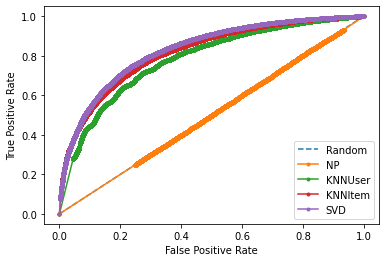

In [22]:
# ROC Function
def plot_roc_curve(Y_test, model_probs, model):
    
    random_probs = [0 for _ in range(len(Y_test))]
    
    # calculate AUC
    model_auc = roc_auc_score(Y_test, model_probs)
    
    # summarize score
    print(f"{model}: ROC AUC={model_auc}")
    
    # calculate ROC Curve
    # For the actual model
    model_fpr, model_tpr, _ = roc_curve(Y_test, model_probs)
    
    # Plot the roc curve for the model and the random model line
    plt.plot(model_fpr, model_tpr, marker=".", label=model)
    

    
# calculate ROC Curve
# For the Random Model
true_values = results["NP"]["true_values"]
random_probs = [0 for _ in range(len(true_values))]
random_fpr, random_tpr, _ = roc_curve(true_values, random_probs)

# Plot the roc curve for the random model line
plt.plot(random_fpr, random_tpr, linestyle="--", label="Random")

# Plot the roc curve for the model and the random model line
for i in results:
    true_values = results[i]["true_values"]
    est = results[i]["est"]
    plot_roc_curve(true_values, est, i)

# Create labels for the axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
# show the legend
plt.legend()
    
# show the plot
plt.show()